In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
winequality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = winequality.data.features
y = winequality.data.targets

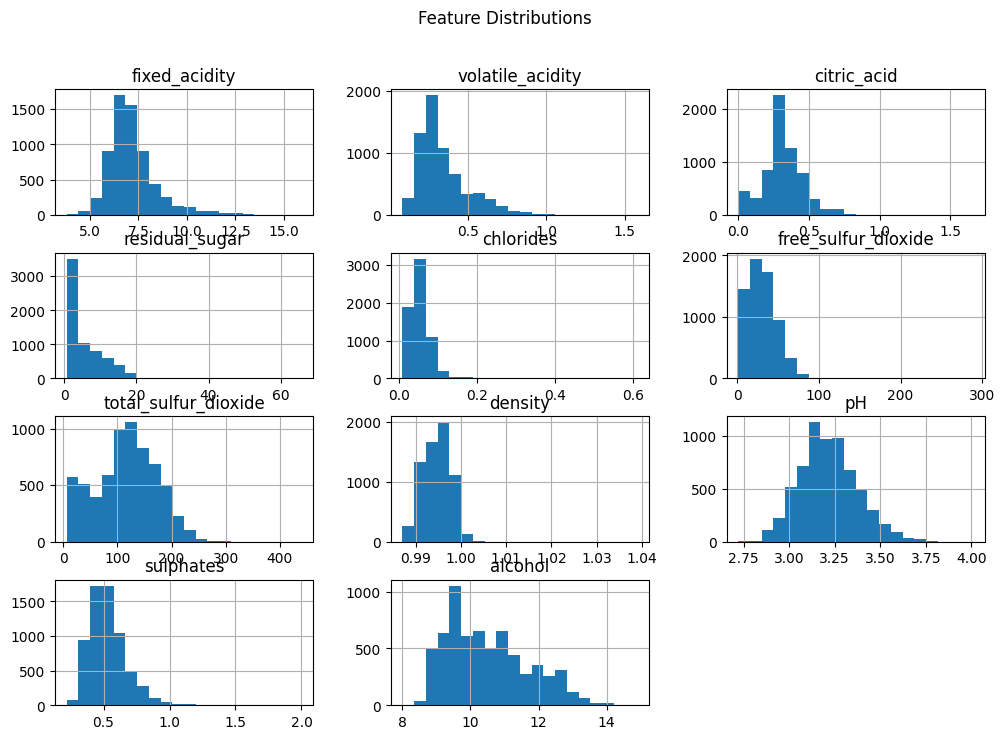

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

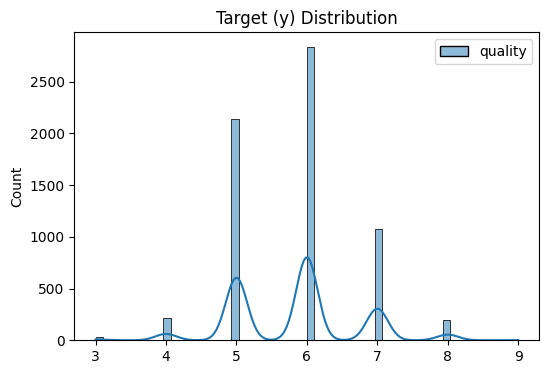

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

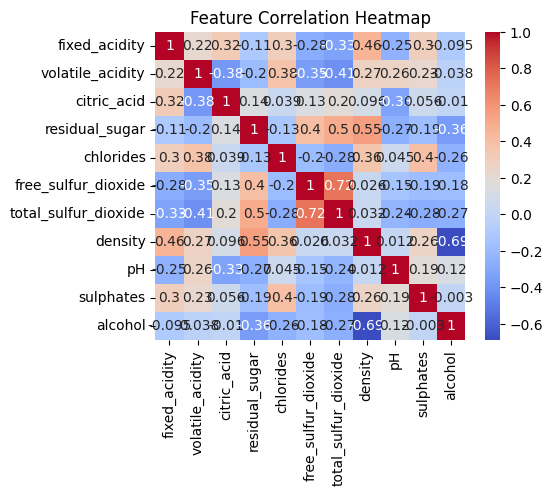

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.206444                 1.044375             1.262182   
1                  1.127947                 1.167949             1.116572   
2                  1.193243                 1.052763             1.135037   
3                  1.103048                 1.178306             1.263147   
4                  1.092721                 1.177739             1.481802   
mean               1.144681                 1.124226             1.251748   
std                0.052168                 0.069251             0.145823   

      DefaultBART_Rhat_RMSE  
0                  1.596865  
1                  1.255078  
2                  1.143354  
3                  1.404727  
4                  1.555566  
mean               1.391118  
std                0.193297  


In [10]:
rhat_df.to_csv("results/real2_WineQuality_rhat.csv", index=False)

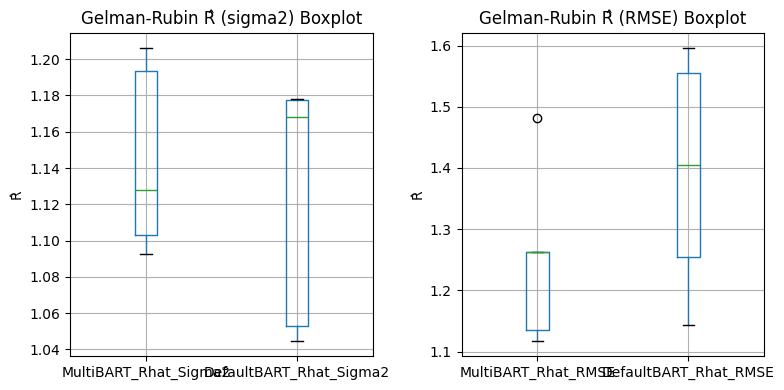

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

INFO:2025-10-28 17:40:52,582:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-10-28 17:41:04,422:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-10-28 17:41:06,685:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to op

test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.472157  0.472380  0.476953  0.389235  0.423869
1      0.448337  0.462784  0.463041  0.359287  0.416377
2      0.486917  0.485031  0.494605  0.384622  0.407832
3      0.459603  0.454098  0.462256  0.346424  0.386311
4      0.451252  0.462465  0.455026  0.363344  0.391157
5      0.463729  0.465608  0.468411  0.369662  0.415728
6      0.462106  0.468984  0.481847  0.377460  0.403745
7      0.473483  0.475095  0.477520  0.379783  0.425224
8      0.428023  0.425487  0.444487  0.332221  0.366885
9      0.507187  0.506482  0.498259  0.427461  0.448023
mean   0.465280  0.467841  0.472241  0.372950  0.408515
std    0.021745  0.020831  0.016948  0.026017  0.022950



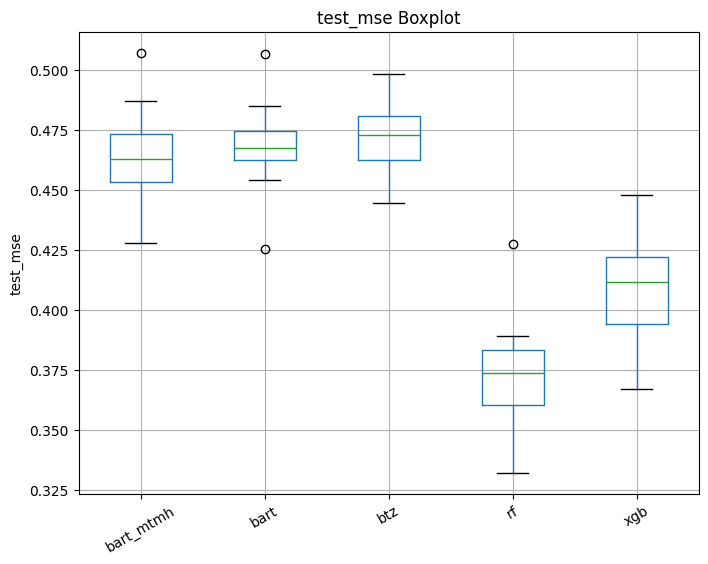

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.358393  0.382994  0.405606  0.051776  0.063149
1      0.369011  0.386024  0.415851  0.053084  0.067435
2      0.355802  0.381564  0.400854  0.051887  0.057334
3      0.366540  0.402374  0.419258  0.054751  0.057431
4      0.371041  0.393385  0.411875  0.051670  0.068970
5      0.360188  0.392141  0.409501  0.051974  0.068156
6      0.365577  0.389672  0.405331  0.051510  0.060060
7      0.354567  0.383729  0.405558  0.051897  0.070524
8      0.374617  0.392666  0.428525  0.053018  0.065569
9      0.346381  0.375470  0.393874  0.049368  0.059666
mean   0.362212  0.388002  0.409623  0.052093  0.063829
std    0.008673  0.007623  0.009832  0.001376  0.004957



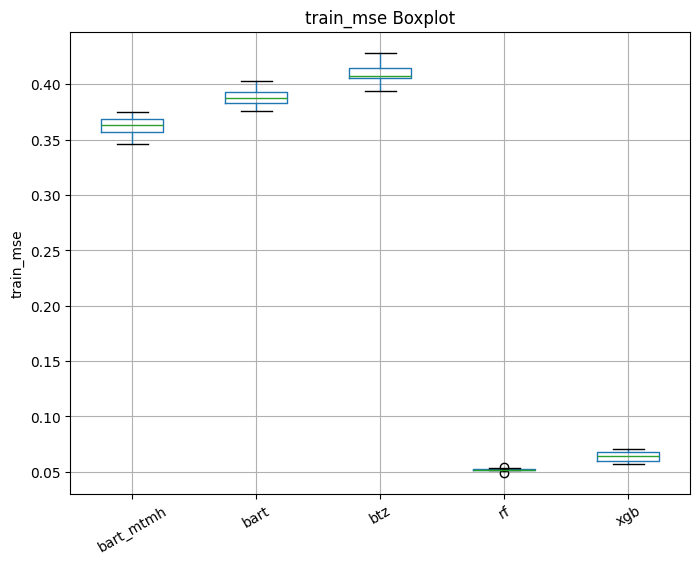

pi_length:
      bart_mtmh      bart       btz
0      2.537690  2.564853  2.652838
1      2.571756  2.572650  2.671906
2      2.534668  2.567847  2.646552
3      2.556885  2.613532  2.677967
4      2.574052  2.563354  2.655693
5      2.556345  2.598409  2.655559
6      2.557603  2.570488  2.665730
7      2.521599  2.556167  2.659986
8      2.568407  2.604018  2.706243
9      2.498755  2.531473  2.637248
mean   2.547776  2.574279  2.662972
std    0.024281  0.024573  0.019251



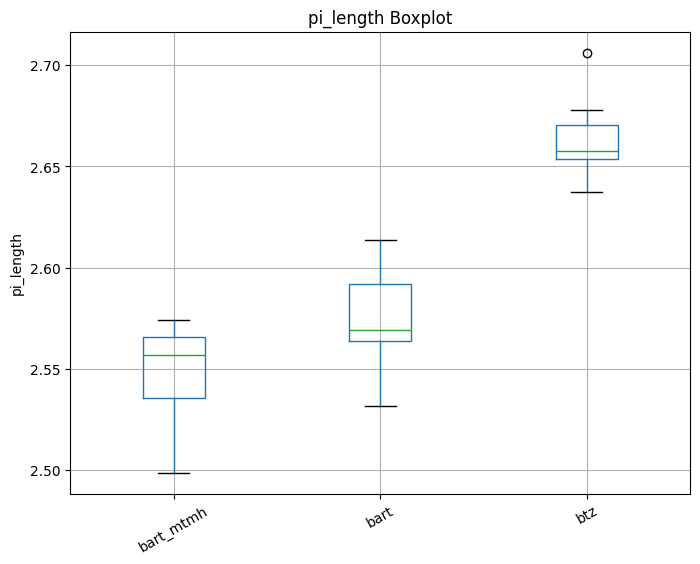

coverage:
      bart_mtmh      bart       btz
0      0.935385  0.934769  0.943385
1      0.942769  0.939077  0.950154
2      0.928615  0.934154  0.939692
3      0.942154  0.943385  0.946462
4      0.939077  0.937846  0.943385
5      0.936615  0.936000  0.937846
6      0.940308  0.936000  0.938462
7      0.937231  0.931692  0.940308
8      0.951385  0.953231  0.954462
9      0.924308  0.924923  0.940923
mean   0.937785  0.937108  0.943508
std    0.007528  0.007440  0.005395



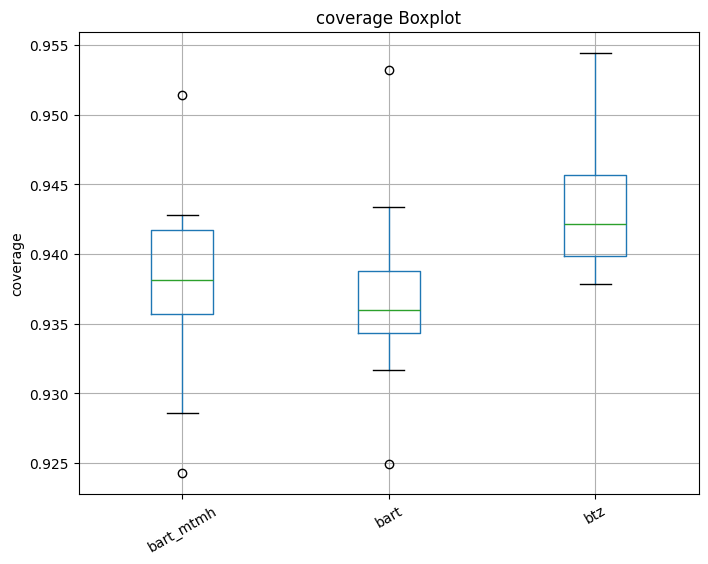

train_time:
       bart_mtmh       bart        btz        rf       xgb
0     245.690296  33.093894  47.542602  4.046439  0.163188
1     234.477538  30.127488  48.708323  4.174592  0.172949
2     255.177592  32.853540  47.058613  4.338384  0.176833
3     258.656551  42.052424  48.430040  4.191107  0.148979
4     240.340101  36.166500  46.853880  4.301814  0.172861
5     246.416650  35.772783  49.147305  4.317419  0.166371
6     252.818464  36.806157  48.438452  4.114992  0.197573
7     256.904187  31.774271  47.866000  4.150769  0.168520
8     260.448739  39.932488  46.667446  4.205418  0.166223
9     257.193639  34.774000  47.640330  4.125931  0.158293
mean  250.812376  35.335354  47.835299  4.196687  0.169179
std     8.675344   3.660600   0.833732  0.095838  0.012789



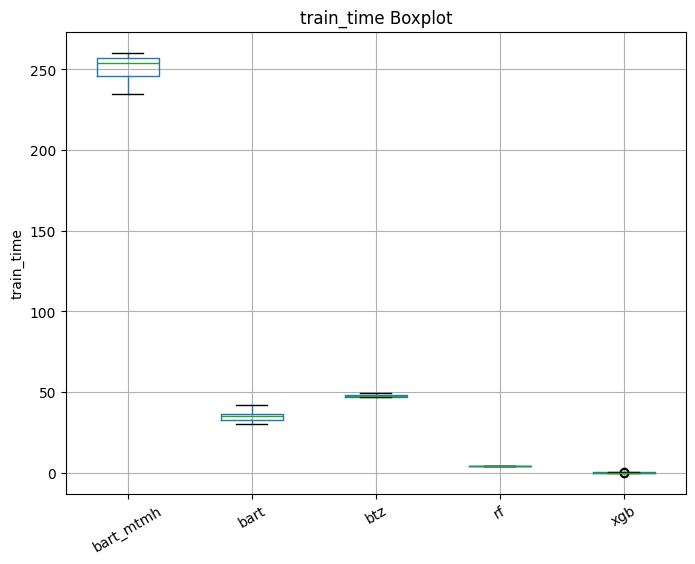

In [12]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [13]:
for k, v in mse_results.items():
    csv_name = f"results/real2_WineQuality_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real2_WineQuality_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50, 100],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real2_WineQuality_tries.csv", index=False)

In [ ]:
import pandas as pd
df = pd.read_csv("results/real2_WineQuality_tries.csv")
print(df)